# Mini-batch FashionMNIST
We shall train a tiny (under 10k params) FashionMNIST convolutional neural network using mini-batch training.

### 1. Introduction

This notebook was ran on a GTX 1650 with 4 GB VRAM.

### 2. Imports

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchzero as tz
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import numpy as np
import random
from torchvision.datasets import FashionMNIST
from light_dataloader import TensorDataLoader

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### 3. Load the dataset

FashionMNIST is like MNIST but a bit harder. Each sample is a single channel 28x28 image and an integer label from 0 to 9.

I stacked the entire dataset into a tensor and move it to GPU for efficiency.

In [2]:
def to_tensors(ds):
    inputs = []
    targets = []
    for input, target in ds:
        inputs.append(torch.tensor(np.array(input), dtype=torch.float32))
        targets.append(torch.tensor(np.array(target), dtype=torch.long))

    # znormalize
    inputs = torch.stack(inputs)
    inputs = (inputs - inputs.mean() / inputs.std())

    return inputs.cuda(), torch.stack(targets).cuda()

fm_train = FashionMNIST("/var/mnt/wwn-0x5000039a52582e84-part1/datasets/FashionMNIST", train=True, download=True)
fm_test = FashionMNIST("/var/mnt/wwn-0x5000039a52582e84-part1/datasets/FashionMNIST", train=False, download=True)

train_X, train_y = to_tensors(fm_train)
test_X, test_y = to_tensors(fm_test)

train_X.unsqueeze_(1)
test_X.unsqueeze_(1)

dl_train = TensorDataLoader((train_X, train_y), batch_size=32, shuffle=True, memory_efficient=True, seed=0)
dl_test = TensorDataLoader((test_X, test_y), batch_size=1024, shuffle=False, memory_efficient=True, seed=0)

train_X.shape, train_y.shape, test_X.shape, test_y.shape

(torch.Size([60000, 1, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000, 1, 28, 28]),
 torch.Size([10000]))

### 4. Define the model

We use a 4-layer convolutional net with 9.6k parameters. The same model was used for full-batched training in another notebook and achieved 90% test accuracy.

In [3]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

class TinyConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = nn.Conv2d(1, 16, 3, 2)
        self.c2 = nn.Conv2d(16, 24, 3, 2)
        self.c3 = nn.Conv2d(24, 32, 2, 2)
        self.head = nn.Sequential(nn.Flatten(), nn.Linear(32*9, 10))

    def forward(self, x):
        x = F.elu(self.c1(x), inplace=True)
        x = F.elu(self.c2(x), inplace=True)
        x = F.elu(self.c3(x), inplace=True)
        return self.head(x)

print(TinyConvNet()(torch.randn(1,1,28,28)).shape)
count_params(TinyConvNet())

torch.Size([1, 10])


9634

### 5. Define the training function

In [ ]:
def train_epoch(dl_train, model, opt, scheduler, criterion):
    losses = []
    accs = []

    for x, y in tqdm.tqdm(dl_train, leave=False, desc='train'):

        accuracy = None

        def closure(backward=True):
            y_hat = model(x)
            loss = criterion(y_hat, y)
            if backward:
                opt.zero_grad()
                loss.backward()

            with torch.no_grad():
                nonlocal accuracy
                accuracy = (y_hat.argmax(-1) == y).float().mean()

            return loss

        loss = opt.step(closure)
        if scheduler is not None: scheduler.step()
        losses.append(loss.detach().cpu())
        accs.append(accuracy.detach().cpu()) # type:ignore

    return losses, accs

@torch.no_grad
def test_epoch(dl_test, model, criterion):
    losses = []
    accs = []

    for x, y in tqdm.tqdm(dl_test, leave=False, desc='test'):
        y_hat = model(x)
        loss = criterion(y_hat, y)
        accuracy = (y_hat.argmax(-1) == y).float().mean()
        losses.append(loss.detach().cpu())
        accs.append(accuracy.detach().cpu())

    return losses, accs

def run(opt_fn, epochs: int, scheduler_fn=None):
    dl_train.reset_rng()
    model = TinyConvNet().cuda()
    opt = opt_fn(model.parameters())
    scheduler = None if scheduler_fn is None else scheduler_fn(opt)
    criterion = F.cross_entropy

    train_losses = []
    train_acc = []
    test_losses = {}
    test_acc = {}

    losses, accs = test_epoch(dl_train, model, criterion)
    test_losses[len(train_losses)] = np.mean(losses)
    test_acc[len(train_losses)] = np.mean(accs)

    for epoch in tqdm.trange(epochs):
        losses, accs = train_epoch(dl_train, model, opt, scheduler, criterion)
        train_losses.extend(losses)
        train_acc.extend(accs)

        losses, accs = test_epoch(dl_train, model, criterion)
        test_losses[len(train_losses)] = np.mean(losses)
        test_acc[len(train_losses)] = np.mean(accs)

    print(f"{max(test_acc.values()) = }")
    print(f'{min(test_losses.values()) = }')

    plt.plot(train_acc, label='train')
    plt.plot(gaussian_filter1d(train_acc, 10, mode='nearest'), label='train (smoothed)')
    plt.plot(*zip(*test_acc.items()), label='test')
    plt.xlabel('number of function evaluations')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

    return model, train_losses, test_losses, train_acc, test_acc

### 6. Run

With Adam we achieve 92% accuracy in under 2 minutes, compared to 90% in 6 minutes in full-batch notebook.

test:   0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

train:   0%|          | 0/1875 [00:00<?, ?it/s]

test:   0%|          | 0/1875 [00:00<?, ?it/s]

train:   0%|          | 0/1875 [00:00<?, ?it/s]

test:   0%|          | 0/1875 [00:00<?, ?it/s]

train:   0%|          | 0/1875 [00:00<?, ?it/s]

test:   0%|          | 0/1875 [00:00<?, ?it/s]

train:   0%|          | 0/1875 [00:00<?, ?it/s]

test:   0%|          | 0/1875 [00:00<?, ?it/s]

train:   0%|          | 0/1875 [00:00<?, ?it/s]

test:   0%|          | 0/1875 [00:00<?, ?it/s]

train:   0%|          | 0/1875 [00:00<?, ?it/s]

test:   0%|          | 0/1875 [00:00<?, ?it/s]

train:   0%|          | 0/1875 [00:00<?, ?it/s]

test:   0%|          | 0/1875 [00:00<?, ?it/s]

train:   0%|          | 0/1875 [00:00<?, ?it/s]

test:   0%|          | 0/1875 [00:00<?, ?it/s]

train:   0%|          | 0/1875 [00:00<?, ?it/s]

test:   0%|          | 0/1875 [00:00<?, ?it/s]

train:   0%|          | 0/1875 [00:00<?, ?it/s]

test:   0%|          | 0/1875 [00:00<?, ?it/s]

max(test_acc.values()) = np.float32(0.92616665)
min(test_losses.values()) = np.float32(0.20091964)


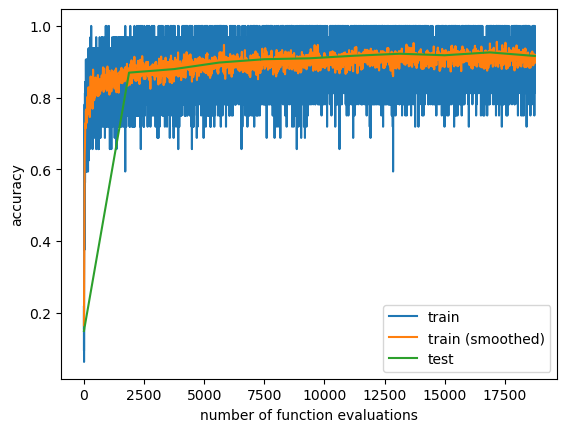

In [ ]:
model, train_losses, test_losses, train_acc, test_acc = run(
    opt_fn = lambda params: tz.Modular(
        params,
        tz.m.Adam(),
        tz.m.LR(1e-3),
    ),
    epochs=30,
)

test:   0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

train:   0%|          | 0/1875 [00:00<?, ?it/s]

test:   0%|          | 0/1875 [00:00<?, ?it/s]

train:   0%|          | 0/1875 [00:00<?, ?it/s]

test:   0%|          | 0/1875 [00:00<?, ?it/s]

train:   0%|          | 0/1875 [00:00<?, ?it/s]

test:   0%|          | 0/1875 [00:00<?, ?it/s]

train:   0%|          | 0/1875 [00:00<?, ?it/s]

test:   0%|          | 0/1875 [00:00<?, ?it/s]

train:   0%|          | 0/1875 [00:00<?, ?it/s]

test:   0%|          | 0/1875 [00:00<?, ?it/s]

train:   0%|          | 0/1875 [00:00<?, ?it/s]

test:   0%|          | 0/1875 [00:00<?, ?it/s]

train:   0%|          | 0/1875 [00:00<?, ?it/s]

test:   0%|          | 0/1875 [00:00<?, ?it/s]

train:   0%|          | 0/1875 [00:00<?, ?it/s]

test:   0%|          | 0/1875 [00:00<?, ?it/s]

train:   0%|          | 0/1875 [00:00<?, ?it/s]

test:   0%|          | 0/1875 [00:00<?, ?it/s]

train:   0%|          | 0/1875 [00:00<?, ?it/s]

test:   0%|          | 0/1875 [00:00<?, ?it/s]

max(test_acc.values()) = np.float32(0.9346333)
min(test_losses.values()) = np.float32(0.1812751)


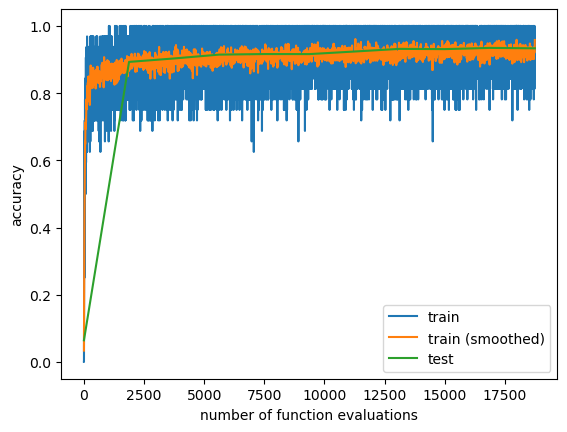

In [6]:
model, train_losses, test_losses, train_acc, test_acc = run(
    opt_fn = lambda params: tz.Modular(
        params,
        tz.m.SOAP(),
        tz.m.LR(1e-3),
    ),
    epochs=10,
)

In [4]:
model, train_losses, test_losses, train_acc, test_acc = run(
    opt_fn = lambda params: tz.Modular(
        params,
        tz.m.SOAP(),
        tz.m.WeightDecay(1e-2),
        tz.m.LR(1e-3),
    ),
    epochs=10,
)

NameError: name 'run' is not defined